Daniel Khalil: 2205957

Philippe Des Boscs: 2176993

Christina Liu: 2205359

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

Question 1 - Data Cleaning and Summary Statistics

In [46]:
crsp_data = pd.read_csv('crsp_1926_2020.csv')

crsp_data_cleaned = crsp_data[(crsp_data['SHRCD'] == 10) | (crsp_data['SHRCD'] == 11)]
crsp_data_cleaned = crsp_data_cleaned[(crsp_data_cleaned['EXCHCD'] == 1) |
                                      (crsp_data_cleaned['EXCHCD'] == 2) |
                                      (crsp_data_cleaned['EXCHCD'] == 3)]
crsp_data_cleaned['PRC'] = crsp_data_cleaned['PRC'].apply(lambda x: x if x >= 0 else np.nan)
crsp_data_cleaned

,PERMNO,date,SHRCD,EXCHCD,PRC,RET,SHROUT
1,10000,1986-01-31,10.0,3.0,NaN,C,3680.0
2,10000,1986-02-28,10.0,3.0,NaN,-0.257143,3680.0
3,10000,1986-03-31,10.0,3.0,NaN,0.365385,3680.0
4,10000,1986-04-30,10.0,3.0,NaN,-0.098592,3793.0
5,10000,1986-05-30,10.0,3.0,NaN,-0.222656,3793.0
...,...,...,...,...,...,...,...
4705164,93436,2020-08-31,11.0,3.0,498.32001,0.741452,931809.0
4705165,93436,2020-09-30,11.0,3.0,429.01001,-0.139087,948000.0
4705166,93436,2020-10-30,11.0,3.0,388.04001,-0.095499,947901.0
4705167,93436,2020-11-30,11.0,3.0,567.59998,0.462736,947901.0


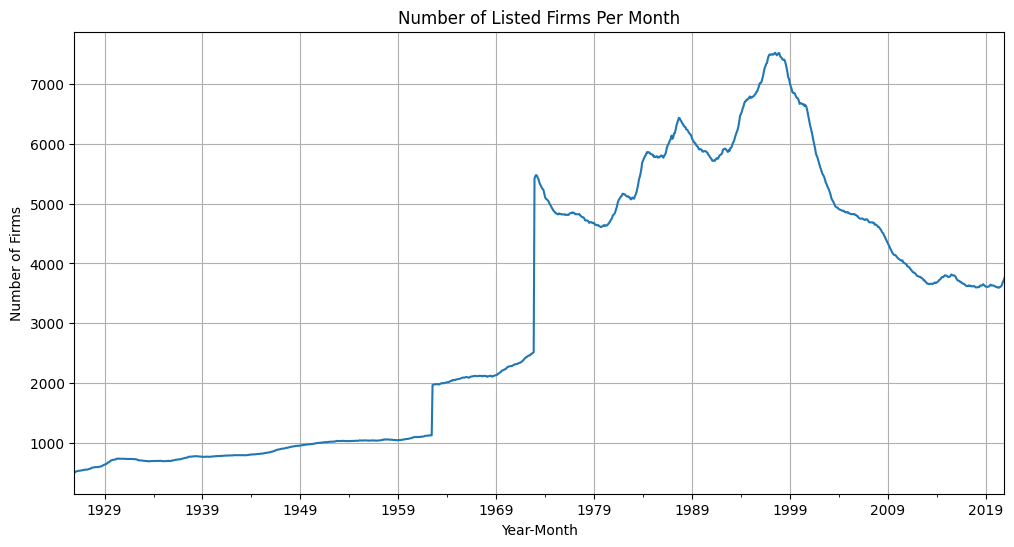

In [47]:
crsp_data_cleaned['date2'] = pd.to_datetime(crsp_data_cleaned['date'], format='%Y-%m-%d')
crsp_data_cleaned['year_month'] = crsp_data_cleaned['date2'].dt.to_period('M')
crsp_data_cleaned['date'] = np.floor(crsp_data_cleaned['date'].str.replace('-','').astype(float)/100).astype(int)
monthly_firms_count = crsp_data_cleaned.groupby('year_month')['PERMNO'].nunique()

monthly_firms_count.plot(kind='line', figsize=(12, 6))
plt.title('Number of Listed Firms Per Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Firms')
plt.grid(True)
plt.show()

Question 2

Part a)

In [48]:
# Market equity for each stock
crsp_data_cleaned['ME'] = (crsp_data_cleaned['PRC'] * crsp_data_cleaned['SHROUT'])/10 # check later

# Make decile
sortdf = crsp_data_cleaned.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT'], axis=1)
sortdf['rank'] = sortdf.groupby('date')['ME'].rank(pct=True)
sortdf['decile'] = np.ceil(sortdf['rank']*10)

def calc_weights(group):
    group['weights_eq'] = 1 / float(group['decile'].count())
    group['TME'] = group['ME'].sum()
    group['weights_val'] = group['ME'] / group['TME']
    return group

sortdf = sortdf.groupby(['date', 'decile']).apply(calc_weights)

sortdf['decile_lag'] = sortdf.groupby('PERMNO')['decile'].shift(1)
sortdf['weights_val_lag'] = sortdf.groupby('PERMNO')['weights_val'].shift(1)
sortdf['weights_eq_lag'] = sortdf.groupby('PERMNO')['weights_eq'].shift(1)


Part b)

In [49]:
sortdf.reset_index(drop = True, inplace = True)
sortdf['RET'] = pd.to_numeric(sortdf['RET'], errors='coerce')

sortdf['weighted_val_ret'] = sortdf['weights_val_lag'] * sortdf['RET']
sortdf['weighted_eq_ret'] = sortdf['weights_eq_lag'] * sortdf['RET']

# Sum up portfolio returns
eqports = sortdf.groupby(['date', 'decile_lag'])['weighted_eq_ret'].sum()
eqports = eqports.unstack()
# Missing accounting data in early years
eqports = eqports.dropna(axis=0)
# Match data format of FF factors
eqports = eqports * 100
eqports = eqports.reset_index()

valports = sortdf.groupby(['date', 'decile_lag'])['weighted_val_ret'].sum()
valports = valports.unstack()
valports = valports.dropna(axis=0)
valports = valports * 100
valports = valports.reset_index()

mean_monthly_returns_eq = eqports.mean(axis=0)
mean_monthly_returns_val = valports.mean(axis=0)

monotonic_eq = (mean_monthly_returns_eq.is_monotonic_increasing or
                mean_monthly_returns_eq.is_monotonic_decreasing)

monotonic_val = (mean_monthly_returns_val.is_monotonic_increasing or
                 mean_monthly_returns_val.is_monotonic_decreasing)

print("Mean monthly returns for each decile (Equal-weighted):")
print(mean_monthly_returns_eq)
print(f"Equal-weighted returns are monotonic: {monotonic_eq}\n")

print("Mean monthly returns for each decile (Value-weighted):")
print(mean_monthly_returns_val)
print(f"Value-weighted returns are monotonic: {monotonic_val}")

Mean monthly returns for each decile (Equal-weighted):
decile_lag
date    197306.500000
1.0          3.117020
2.0          1.502364
3.0          1.330793
4.0          1.273380
5.0          1.262522
6.0          1.221263
7.0          1.161920
8.0          1.091310
9.0          1.073214
10.0         0.920555
dtype: float64
Equal-weighted returns are monotonic: True

Mean monthly returns for each decile (Value-weighted):
decile_lag
date    197306.500000
1.0          2.478629
2.0          1.479960
3.0          1.336647
4.0          1.268084
5.0          1.258483
6.0          1.223613
7.0          1.159447
8.0          1.081011
9.0          1.067123
10.0         0.910811
dtype: float64
Value-weighted returns are monotonic: True


Yes, the mean monthly returns for each decile for the equal- and value-weighted portfolios are monotonic. In both cases, the average monthly return decreases as the decile increases. In other word decile 1 has the best average monthly return while decile 10 has the worse.

In [50]:
eqports['1-10'] = eqports[1.0] - eqports[10.0]
valports['1-10'] = valports[1.0] - valports[10.0] 

mean_long_short_eq = eqports['1-10'].mean()
mean_long_short_val = valports['1-10'].mean()

vol_long_short_eq = eqports['1-10'].std()
vol_long_short_val = valports['1-10'].std()

sharpe_ratio_eq = mean_long_short_eq / vol_long_short_eq
sharpe_ratio_val = mean_long_short_val / vol_long_short_val

print(f"Equal-Weighted Long-Short Portfolio:")
print(f"Mean Return: {mean_long_short_eq}")
print(f"Volatility: {vol_long_short_eq}")
print(f"Sharpe Ratio: {sharpe_ratio_eq}\n")

print(f"Value-Weighted Long-Short Portfolio:")
print(f"Mean Return: {mean_long_short_val}")
print(f"Volatility: {vol_long_short_val}")
print(f"Sharpe Ratio: {sharpe_ratio_val}\n")


Equal-Weighted Long-Short Portfolio:
Mean Return: 2.196465045619146
Volatility: 15.065437159855007
Sharpe Ratio: 0.14579497576559441

Value-Weighted Long-Short Portfolio:
Mean Return: 1.5678189607302107
Volatility: 12.93038603178765
Sharpe Ratio: 0.12125074664251588



Part d)

In [51]:
ff3 = pd.read_csv('ff3_factors.csv')
ff3_merged_eq = pd.merge(eqports, ff3, on='date')
ff3_merged_val = pd.merge(valports, ff3, on='date')

# Estimate CAPM - equally weighted
capm_eq=sm.OLS(ff3_merged_eq['1-10'],
              sm.add_constant(ff3_merged_eq[['Mkt-RF']])).fit()

alpha = capm_eq.params.iloc[0]
beta = capm_eq.params.iloc[1]
alpha_pvalue = capm_eq.pvalues.iloc[0]
beta_pvalue = capm_eq.pvalues.iloc[1]

print('Estimate CAPM - equally weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

# Estimate CAPM - value weighted
capm_val=sm.OLS(ff3_merged_val['1-10'],
              sm.add_constant(ff3_merged_val[['Mkt-RF']])).fit()

alpha = capm_val.params.iloc[0]
beta = capm_val.params.iloc[1]
alpha_pvalue = capm_val.pvalues.iloc[0]
beta_pvalue = capm_val.pvalues.iloc[1]

print('\n\nEstimate CAPM - value weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')


Estimate CAPM - equally weighted portfolio:

alpha value: 1.4284969550489417
beta value: 1.1613568362950475
alpha p-value value: 0.0005434886960075301
beta p-value: 1.0774328680137988e-47


Estimate CAPM - value weighted portfolio:

alpha value: 0.8520223983604259
beta value: 1.0679883848088303
alpha p-value value: 0.014509506567112062
beta p-value: 2.6605356905658286e-55


In [52]:
# Estimate FF3 - equally weighted
ff3_eq=sm.OLS(ff3_merged_eq['1-10'],
              sm.add_constant(ff3_merged_eq[['Mkt-RF', 'SMB', 'HML']])).fit()

alpha = ff3_eq.params.iloc[0]
beta = ff3_eq.params.iloc[1]
alpha_pvalue = ff3_eq.pvalues.iloc[0]
beta_pvalue = ff3_eq.pvalues.iloc[1]

print('Estimate FF3 - equally weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

# Estimate FF3 - value weighted
ff3_val=sm.OLS(ff3_merged_val['1-10'],
              sm.add_constant(ff3_merged_val[['Mkt-RF', 'SMB', 'HML']])).fit()

alpha = ff3_val.params.iloc[0]
beta = ff3_val.params.iloc[1]
alpha_pvalue = ff3_val.pvalues.iloc[0]
beta_pvalue = ff3_val.pvalues.iloc[1]

print('\n\nEstimate FF3 - value weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

Estimate FF3 - equally weighted portfolio:

alpha value: 0.8849038131408473
beta value: 0.4144864644543328
alpha p-value value: 0.0024990540943616336
beta p-value: 2.235890400005867e-12


Estimate FF3 - value weighted portfolio:

alpha value: 0.3758447723149844
beta value: 0.39901444466792174
alpha p-value value: 0.10405540470828431
beta p-value: 1.9438340400850038e-17


The CAPM model estimation finds that the equally weighted portfolio has a higher alpha than the value weighted one. The difference is pretty considerable with 1.43 vs 0.85. We notice that the beta value is higher for the value weighted portfolio as well.

The FF3 model also finds that the equally weighted portfolio has a higher alpha than the value weighted one. Once again, the difference is pretty considerable with 0.88 vs 0.38. We notice that the beta value is higher for the value weighted portfolio as well.

Part e)

Fama French 1992

In [53]:
ff1992_eq = ff3_merged_eq[ff3_merged_eq['date']> 199200].copy()
ff1992_val = ff3_merged_val[ff3_merged_val['date']> 199200].copy()

CAPM model for both equal and value weighted portfolios

In [54]:
capm_eq=sm.OLS(ff1992_eq['1-10'], sm.add_constant(ff1992_eq[['Mkt-RF']])).fit()

alpha = capm_eq.params.iloc[0]
beta = capm_eq.params.iloc[1]
alpha_pvalue = capm_eq.pvalues.iloc[0]
beta_pvalue = capm_eq.pvalues.iloc[1]

print('Estimate CAPM after 1992 - equally weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

capm_val=sm.OLS(ff1992_val['1-10'], sm.add_constant(ff1992_val[['Mkt-RF']])).fit()

alpha = capm_val.params.iloc[0]
beta = capm_val.params.iloc[1]
alpha_pvalue = capm_val.pvalues.iloc[0]
beta_pvalue = capm_val.pvalues.iloc[1]

print('\n\n Estimate CAPM after 1992 - value weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')



Estimate CAPM after 1992 - equally weighted portfolio:

alpha value: 1.6375023392393535
beta value: 0.18511892009748446
alpha p-value value: 8.952326586570489e-05
beta p-value: 0.049598224547884304


 Estimate CAPM after 1992 - value weighted portfolio:

alpha value: 0.7939763848996699
beta value: 0.22260020027709604
alpha p-value value: 0.039892015309575514
beta p-value: 0.011440649793083093


FF3 model for both equal and value weighted portfolios

In [55]:
ff3_eq=sm.OLS(ff1992_eq['1-10'], sm.add_constant(ff1992_eq[['Mkt-RF', 'SMB', 'HML']])).fit()

alpha = ff3_eq.params.iloc[0]
beta = ff3_eq.params.iloc[1]
alpha_pvalue = ff3_eq.pvalues.iloc[0]
beta_pvalue = ff3_eq.pvalues.iloc[1]

print('Estimate FF3 after 1992 - equally weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

ff3_val=sm.OLS(ff1992_val['1-10'], sm.add_constant(ff1992_val[['Mkt-RF', 'SMB', 'HML']])).fit()

alpha = ff3_val.params.iloc[0]
beta = ff3_val.params.iloc[1]
alpha_pvalue = ff3_val.pvalues.iloc[0]
beta_pvalue = ff3_val.pvalues.iloc[1]

print('\n\n Estimate FF3 after 1992 - value weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

Estimate FF3 after 1992 - equally weighted portfolio:

alpha value: 1.6172170370912
beta value: -0.0024022215993079465
alpha p-value value: 2.243428637860019e-05
beta p-value: 0.9782939566119688


 Estimate FF3 after 1992 - value weighted portfolio:

alpha value: 0.7525545179970818
beta value: 0.013784575767751026
alpha p-value value: 0.024010168581136644
beta p-value: 0.8595487542932182


Dotcom bubble

CAPM model for both equal and value weighted portfolios

In [56]:
dc2002_eq = ff3_merged_eq[ff3_merged_eq['date']> 200200].copy()
dc2002_val = ff3_merged_val[ff3_merged_val['date']> 200200].copy()

CAPM model for both equal and value weighted portfolios

In [57]:
capm_eq=sm.OLS(dc2002_eq['1-10'], sm.add_constant(dc2002_eq[['Mkt-RF']])).fit()

alpha = capm_eq.params.iloc[0]
beta = capm_eq.params.iloc[1]
alpha_pvalue = capm_eq.pvalues.iloc[0]
beta_pvalue = capm_eq.pvalues.iloc[1]

print('Estimate CAPM after 2002 - equally weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

capm_val=sm.OLS(dc2002_val['1-10'], sm.add_constant(dc2002_val[['Mkt-RF']])).fit()

alpha = capm_val.params.iloc[0]
beta = capm_val.params.iloc[1]
alpha_pvalue = capm_val.pvalues.iloc[0]
beta_pvalue = capm_val.pvalues.iloc[1]

print('\n\nEstimate CAPM after 2002 - value weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

Estimate CAPM after 2002 - equally weighted portfolio:

alpha value: 1.1123500918318416
beta value: 0.2782579284026197
alpha p-value value: 0.006918957617585194
beta p-value: 0.0026101034786650407


Estimate CAPM after 2002 - value weighted portfolio:

alpha value: 0.47997087227799873
beta value: 0.333240995778703
alpha p-value value: 0.21353923820900866
beta p-value: 0.0001443127135931797


FF3 model for both equal and value weighted portfolios

In [58]:
ff3_eq=sm.OLS(dc2002_eq['1-10'],
              sm.add_constant(dc2002_eq[['Mkt-RF', 'SMB', 'HML']])).fit()

alpha = ff3_eq.params.iloc[0]
beta = ff3_eq.params.iloc[1]
alpha_pvalue = ff3_eq.pvalues.iloc[0]
beta_pvalue = ff3_eq.pvalues.iloc[1]

print('Estimate FF3 after 2002 - equally weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')


ff3_val=sm.OLS(dc2002_val['1-10'],
              sm.add_constant(dc2002_val[['Mkt-RF', 'SMB', 'HML']])).fit()

alpha = ff3_val.params.iloc[0]
beta = ff3_val.params.iloc[1]
alpha_pvalue = ff3_val.pvalues.iloc[0]
beta_pvalue = ff3_val.pvalues.iloc[1]

print('\n\nEstimate FF3 after 2002 - value weighted portfolio:\n')
print(f'alpha value: {alpha}')
print(f'beta value: {beta}')
print(f'alpha p-value value: {alpha_pvalue}')
print(f'beta p-value: {beta_pvalue}')

Estimate FF3 after 2002 - equally weighted portfolio:

alpha value: 1.0468929830810216
beta value: 0.11819787835982692
alpha p-value value: 0.007814066154051275
beta p-value: 0.21036170570376062


Estimate FF3 after 2002 - value weighted portfolio:

alpha value: 0.4276440200657776
beta value: 0.1319436415363685
alpha p-value value: 0.22916658805033038
beta p-value: 0.12446099759392908


Looking at the CAPM model estimate, the alphas for the equally weighted portfolio have evolved from 1.43 over the entire dataset, to 1.64 after 1992, and to 1.11 after 2002. It's interesting to see that the period with the highest alpha is from 1992 when the Fama French paper was published. Perhaps, many people followed that strategy after its publication leading to an overall movement in the market that drove up the price of selected stocks. The dotcom bubble seems to have negatively impacted that strategy though as past that point, the alpha is only 1.11. It still remains very good though which suggests that size still works indeed!

Looking at the CAPM model estimate, the alphas for the value weighted portfolio have evolved from 0.38 over the entire dataset, to 0.79 after 1992, and to 0.48 after 2002. We observe the same pattern across time as for the equal weighted portfolio. The dotcom bubble seems to have negatively impacted that strategy though as past that point, the alpha is only 0.48. It still remains decently good though which once again goes in the favor of size.

Looking at the FF3 model estimate, the alphas for the equally weighted portfolio have evolved from 0.88 over the entire dataset, to 1.62 after 1992, and to 1.04 after 2002. This remains very similar to what we saw with the CAPM estimate. We notice though that after the dotcom bubble burst, the alpha is higher than it is over the entire dataset. The alpha still remains relatively high suggesting yet again that size still works (at least past 2002).

Finally, looking at the FF3 model estimate, the alphas for the value weighted portfolio have evolved from 0.38 over the entire dataset, to 0.75 after 1992, and to 0.43 after 2002. This is also very similar to what we saw with the CAPM estimate. The alpha remains relatively high suggesting yet again that size still works.

Question 3

Part a

In [ ]:
# Convert 'RET' column to numeric, turning non-numeric values into NaN
crsp_data_cleaned['RET'] = pd.to_numeric(crsp_data_cleaned['RET'], errors='coerce')

# Now you can calculate the rolling cumulative returns
crsp_data_cleaned['cumulative_returns'] = crsp_data_cleaned.groupby('PERMNO')['RET'].rolling(window=11, min_periods=11).apply(lambda x: np.prod(1+x)-1, raw=True).shift(2).reset_index(0,drop=True)

In [ ]:
# Make decile
sortdf = crsp_data_cleaned.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT'], axis=1)
sortdf['rank'] = sortdf.groupby('date')['cumulative_returns'].rank(pct=True)
sortdf['decile'] = np.ceil(sortdf['rank']*10)

In [ ]:
sortdf

,PERMNO,date,RET,date2,year_month,ME,cumulative_returns,rank,decile
1,10000,198601,NaN,1986-01-31,1986-01,NaN,NaN,NaN,NaN
2,10000,198602,-0.257143,1986-02-28,1986-02,NaN,NaN,NaN,NaN
3,10000,198603,0.365385,1986-03-31,1986-03,NaN,NaN,NaN,NaN
4,10000,198604,-0.098592,1986-04-30,1986-04,NaN,NaN,NaN,NaN
5,10000,198605,-0.222656,1986-05-30,1986-05,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4705164,93436,202008,0.741452,2020-08-31,2020-08,4.643391e+07,5.341741,0.993531,10.0
4705165,93436,202009,-0.139087,2020-09-30,2020-09,4.067015e+07,9.344169,0.998825,10.0
4705166,93436,202010,-0.095499,2020-10-30,2020-10,3.678235e+07,5.811416,0.995022,10.0
4705167,93436,202011,0.462736,2020-11-30,2020-11,5.380286e+07,4.880464,0.994435,10.0


In [ ]:
# Form the equal- and value-weighted portfolios for the ten momentum portfolios
def calc_weights(group):
    group['weights_eq'] = 1 / float(group['decile'].count())
    group['TME'] = group['ME'].sum()
    group['weights_val'] = group['ME'] / group['TME']
    return group

sortdf = sortdf.groupby(['date', 'decile']).apply(calc_weights)

sortdf['decile_lag'] = sortdf.groupby('PERMNO')['decile'].shift(1)
sortdf['weights_val_lag'] = sortdf.groupby('PERMNO')['weights_val'].shift(1)
sortdf['weights_eq_lag'] = sortdf.groupby('PERMNO')['weights_eq'].shift(1)

In [ ]:
sortdf

PERMNO    date       RET      date2 year_month  \
date   decile                                                           
192611 1.0    9832      10057  192611 -0.316239 1926-11-30    1926-11   
              32357     10188  192611 -0.097222 1926-11-30    1926-11   
              33968     10196  192611  0.137931 1926-11-30    1926-11   
              36184     10209  192611  0.353659 1926-11-30    1926-11   
              87182     10524  192611  0.085271 1926-11-30    1926-11   
...                       ...     ...       ...        ...        ...   
202012 10.0   4689308   93263  202012  0.560000 2020-12-31    2020-12   
              4690300   93272  202012  0.256757 2020-12-31    2020-12   
              4691300   93285  202012  0.377810 2020-12-31    2020-12   
              4701611   93393  202012  0.091997 2020-12-31    2020-12   
              4705168   93436  202012  0.243252 2020-12-31    2020-12   

                                 ME  cumulative_returns      rank  decile  \
date   decile                                                               
192611 1.0    9832     2.500000e+02           -0.591837  0.036036     1.0   
              32357    3.363750e+02           -0.503816  0.063063     1.0   
              33968    1.518000e+03           -0.604790  0.029279     1.0   
              36184    4.620375e+02           -0.476416  0.081081     1.0   
              87182    1.750000e+03           -0.469698  0.090090     1.0   
...                             ...                 ...       ...     ...   
202012 10.0   4689308  3.635552e+05            8.316665  0.997368    10.0   
              4690300  1.838364e+05            2.248915  0.961696    10.0   
              4691300  1.170499e+04            1.842183  0.950292    10.0   
              4701611  1.050616e+05            1.708718  0.943567    10.0   
              4705168  6.773402e+07            4.423475  0.989181    10.0   

                       weights_eq           TME  weights_val  decile_lag  \
date   decile                                                              
192611 1.0    9832       0.022727  2.641839e+04     0.009463         NaN   
              32357      0.022727  2.641839e+04     0.012733         NaN   
              33968      0.022727  2.641839e+04     0.057460         NaN   
              36184      0.022727  2.641839e+04     0.017489         NaN   
              87182      0.022727  2.641839e+04     0.066242         NaN   
...                           ...           ...          ...         ...   
202012 10.0   4689308    0.002924  2.587657e+08     0.001405        10.0   
              4690300    0.002924  2.587657e+08     0.000710        10.0   
              4691300    0.002924  2.587657e+08     0.000045         9.0   
              4701611    0.002924  2.587657e+08     0.000406        10.0   
              4705168    0.002924  2.587657e+08     0.261758        10.0   

                       weights_val_lag  weights_eq_lag  
date   decile                                           
192611 1.0    9832                 NaN             NaN  
              32357                NaN             NaN  
              33968                NaN             NaN  
              36184                NaN             NaN  
              87182                NaN             NaN  
...                                ...             ...  
202012 10.0   4689308         0.000804        0.002924  
              4690300         0.000509        0.002924  
              4691300         0.000011        0.002933  
              4701611         0.000334        0.002924  
              4705168         0.187239        0.002924  

[3279165 rows x 15 columns]

Part b

In [ ]:
sortdf.reset_index(drop = True, inplace = True)
sortdf['weighted_val_lag'] = sortdf['weights_val_lag'] * sortdf['RET']
sortdf['weighted_eq_lag'] = sortdf['weights_eq_lag'] * sortdf['RET']

# Sum up portfolio returns
eqports = sortdf.groupby(['date', 'decile_lag'])['weighted_eq_lag'].sum()
eqports = eqports.unstack()
# Missing accounting data in early years
eqports = eqports.dropna(axis=0)
# Match data format of FF factors
eqports = eqports * 100
eqports = eqports.reset_index()

valports = sortdf.groupby(['date', 'decile_lag'])['weighted_val_lag'].sum()
valports = valports.unstack()
valports = valports.dropna(axis=0)
valports = valports * 100
valports = valports.reset_index()

mean_monthly_returns_eq = eqports.mean(axis=0)
mean_monthly_returns_val = valports.mean(axis=0)

monotonic_eq = (mean_monthly_returns_eq.is_monotonic_increasing or
                mean_monthly_returns_eq.is_monotonic_decreasing)

monotonic_val = (mean_monthly_returns_val.is_monotonic_increasing or
                 mean_monthly_returns_val.is_monotonic_decreasing)

print("Mean monthly returns for each decile (Equal-weighted):")
print(mean_monthly_returns_eq)
print(f"Equal-weighted returns are monotonic: {monotonic_eq}\n")

print("Mean monthly returns for each decile (Value-weighted):")
print(mean_monthly_returns_val)
print(f"Value-weighted returns are monotonic: {monotonic_val}")

eqports

Mean monthly returns for each decile (Equal-weighted):
decile_lag
date    197352.287865
1.0          1.144305
2.0          1.064822
3.0          1.217383
4.0          1.170327
5.0          1.219944
6.0          1.303896
7.0          1.410952
8.0          1.440834
9.0          1.539089
10.0         1.744611
dtype: float64
Equal-weighted returns are monotonic: False

Mean monthly returns for each decile (Value-weighted):
decile_lag
date    197352.287865
1.0          0.228607
2.0          0.533213
3.0          0.782392
4.0          0.903838
5.0          0.927468
6.0          0.973006
7.0          1.068319
8.0          1.155728
9.0          1.235009
10.0         1.479964
dtype: float64
Value-weighted returns are monotonic: False


decile_lag,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,192601,0.001209,1.649523,0.407028,0.878536,1.416923,4.211967,-0.593649,1.557935,-0.237902,1.934547
1,192701,0.375342,-9.314924,7.988318,5.855666,1.500217,8.741004,-3.039191,0.567937,-0.213094,0.168475
2,192702,5.429484,6.045233,14.772018,26.628656,6.068283,5.879763,3.624080,5.895644,5.496386,5.259776
3,192703,-10.764280,-3.066426,2.790509,-2.690691,-6.627557,-1.865443,-15.965384,-0.490007,20.923493,3.651683
4,192704,0.708904,-9.864522,-0.692226,2.751067,-0.319615,-5.386724,1.436915,-0.911465,-2.914733,4.136957
...,...,...,...,...,...,...,...,...,...,...,...
1124,202008,3.599718,5.094813,6.928604,4.340953,6.657829,4.595906,5.090737,4.312206,3.172607,3.541746
1125,202009,-6.160866,-4.422428,-3.312075,-3.005215,-2.547669,-2.118888,-2.465467,-1.957995,-1.442655,0.558763
1126,202010,-2.315287,3.229721,4.299260,2.142781,2.828298,1.945891,1.904596,0.000267,0.726221,-2.216531
1127,202011,38.188981,23.794518,20.576148,19.699745,16.514408,16.663575,17.467311,15.855039,14.682045,20.481395


Part c

In [ ]:
# Form the long-short winners-minus-losers portfolio
eqports['10-1'] = eqports[10.0] - eqports[1.0]
valports['10-1'] = valports[10.0] - valports[1.0] 

mean_long_short_eq = eqports['10-1'].mean()
mean_long_short_val = valports['10-1'].mean()

vol_long_short_eq = eqports['10-1'].std()
vol_long_short_val = valports['10-1'].std()

sharpe_ratio_eq = mean_long_short_eq / vol_long_short_eq
sharpe_ratio_val = mean_long_short_val / vol_long_short_val

print(f"Equal-Weighted Long-Short Portfolio:")
print(f"Mean Return: {mean_long_short_eq}")
print(f"Volatility: {vol_long_short_eq}")
print(f"Sharpe Ratio: {sharpe_ratio_eq}\n")

print(f"Value-Weighted Long-Short Portfolio:")
print(f"Mean Return: {mean_long_short_val}")
print(f"Volatility: {vol_long_short_val}")
print(f"Sharpe Ratio: {sharpe_ratio_val}\n")

Equal-Weighted Long-Short Portfolio:
Mean Return: 0.6003058776220164
Volatility: 8.071971118712762
Sharpe Ratio: 0.07436918056239865

Value-Weighted Long-Short Portfolio:
Mean Return: 1.2513567758419675
Volatility: 8.47887052551482
Sharpe Ratio: 0.14758531482186865



Part d

In [ ]:
ff3 = pd.read_csv('ff3_factors.csv')
ff5 = pd.read_csv('ff5_factors.csv')
#make Date into date
ff3.rename(columns={'Date': 'date'}, inplace=True)
ff5.rename(columns={'Date': 'date'}, inplace=True)
ff3_merged_eq = pd.merge(eqports, ff3, on='date')
ff3_merged_val = pd.merge(valports, ff3, on='date')
ff5_merged_eq = pd.merge(eqports, ff5, on='date')
ff5_merged_val = pd.merge(valports, ff5, on='date')

# Estimate CAPM - equally weighted
model1=sm.OLS(ff3_merged_eq['10-1'],
              sm.add_constant(ff3_merged_eq[['Mkt-RF']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     93.15
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           3.13e-21
Time:                        22:26:09   Log-Likelihood:                -3911.4
No. Observations:                1128   AIC:                             7827.
Df Residuals:                    1126   BIC:                             7837.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8812      0.233      3.782      0.0

In [ ]:
# Estimate CAPM - value weighted
model1=sm.OLS(ff3_merged_val['10-1'],
              sm.add_constant(ff3_merged_val[['Mkt-RF']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     169.0
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           4.16e-36
Time:                        22:26:34   Log-Likelihood:                -3932.9
No. Observations:                1128   AIC:                             7870.
Df Residuals:                    1126   BIC:                             7880.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6393      0.237      6.903      0.0

In [ ]:
# Estimate FF3 - equally weighted
model1=sm.OLS(ff3_merged_eq['10-1'],
              sm.add_constant(ff3_merged_eq[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     113.6
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           2.93e-64
Time:                        22:26:46   Log-Likelihood:                -3806.9
No. Observations:                1128   AIC:                             7622.
Df Residuals:                    1124   BIC:                             7642.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0890      0.213      5.111      0.0

In [ ]:
# Estimate FF3 - value weighted
model1=sm.OLS(ff3_merged_val['10-1'],
              sm.add_constant(ff3_merged_val[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     117.1
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           5.41e-66
Time:                        22:26:59   Log-Likelihood:                -3858.3
No. Observations:                1128   AIC:                             7725.
Df Residuals:                    1124   BIC:                             7745.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8253      0.223      8.186      0.0

In [ ]:
# Estimate FF5 - equally weighted
model1=sm.OLS(ff5_merged_eq['10-1'],
              sm.add_constant(ff5_merged_eq[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     12.33
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           1.81e-11
Time:                        22:27:04   Log-Likelihood:                -2281.9
No. Observations:                 690   AIC:                             4576.
Df Residuals:                     684   BIC:                             4603.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5677      0.264      2.149      0.0

In [ ]:
# Estimate FF5 - value weighted
model1=sm.OLS(ff5_merged_val['10-1'],
              sm.add_constant(ff5_merged_val[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   10-1   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     16.00
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           6.32e-15
Time:                        22:27:16   Log-Likelihood:                -2374.8
No. Observations:                 690   AIC:                             4762.
Df Residuals:                     684   BIC:                             4789.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6945      0.302      5.606      0.0

Comparing the CAPM, FF3, and FF5 equal-weighted alphas to the value-weighted alphas, we can see that the value-weighted portfolio performs much better, potentially implying that larger firms experience the effects of momentum more noticeably. We also notice that the CAPM, FF3, and FF5 models generally generate alphas that are statistically significant at the 5% level. Additionally, we can see that under the FF5 model, the alphas for both the equal-weighted and value-weighted drop slightly, suggesting that the FF5 model does price momentum to some degree.

Part e

The high momentum alphas are not necessarily indicative of managerial skill. High alphas can also be a result of taking on additional risk that is not accounted for in the model. For example, the momentum strategy is known to have crash risk, and it tends to perform poorly in extreme down markets. If the model does not account for this risk, it can show up as positive alpha. Thus, while a positive alpha could be indicative of managerial skill, it could also be a sign of additional unaccounted risks or model misspecification.

Question 4

In [ ]:
from statsmodels.regression.rolling import RollingOLS

# Convert 'RET' column to numeric, turning non-numeric values into NaN
crsp_data_cleaned['RET'] = pd.to_numeric(crsp_data_cleaned['RET'], errors='coerce')

# Merge ff5 and crsp
merged_df = pd.merge(crsp_data_cleaned, ff3, on='date', how='inner')

# Define a function to calculate rolling betas
def calc_rolling_beta(group):
    if len(group) >= 36:
        endog = group['RET']*100 - group['RF']
        exog = sm.add_constant(group['Mkt-RF'])  # Add a constant to the exogenous variable
        model = RollingOLS(endog, exog, window=36)
        rolling_params = model.fit().params
        group['rolling_beta'] = rolling_params['Mkt-RF'].values
    else:
        group['rolling_beta'] = np.nan
    return group

merged_df = merged_df.groupby('PERMNO').apply(calc_rolling_beta)

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = ssr / (nobs - tot_params)
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\rolling.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  s

In [ ]:
#merged_df.to_csv('merged_df.csv', index=False)

# Now, to load the data back into a DataFrame
merged_df = pd.read_csv('merged_df.csv')
merged_df["rolling_beta"] = merged_df.groupby('PERMNO')['rolling_beta'].shift(1)

In [ ]:
# Drop rows with NaN values in 'rolling_beta'
merged_df = merged_df.dropna(subset=['rolling_beta'])

# Make decile
sortdf = merged_df.drop(['SHRCD', 'EXCHCD', 'PRC', 'SHROUT'], axis=1)
sortdf['rank'] = sortdf.groupby('date')['rolling_beta'].rank(pct=True)
sortdf['decile'] = np.ceil(sortdf['rank']*10)

In [ ]:
sortdf.reset_index(drop = True, inplace = True)

# Form the equal- and value-weighted portfolios for the ten momentum portfolios
def calc_weights(group):
    group['weights_eq'] = 1 / float(group['decile'].count())
    group['TME'] = group['ME'].sum()
    group['weights_val'] = group['ME'] / group['TME']
    return group

sortdf = sortdf.groupby(['date', 'decile']).apply(calc_weights)

sortdf['decile_lag'] = sortdf.groupby('PERMNO')['decile'].shift(1)
sortdf['weights_val_lag'] = sortdf.groupby('PERMNO')['weights_val'].shift(1)
sortdf['weights_eq_lag'] = sortdf.groupby('PERMNO')['weights_eq'].shift(1)

In [ ]:
sortdf

,PERMNO,date,RET,date2,year_month,ME,cumulative_returns,Mkt-RF,SMB,HML,...,rank,decile,weights_eq,TME,weights_val,decile_lag,weights_val_lag,weights_eq_lag,weighted_val_lag,weighted_eq_lag
0,11404,192607,0.107323,1926-07-31,1926-07,39465.000,NaN,2.96,-2.56,-2.43,...,0.044944,1.0,0.125000,8.615805e+04,0.458054,NaN,NaN,NaN,NaN,NaN
1,11674,192607,0.018657,1926-07-31,1926-07,10988.250,NaN,2.96,-2.56,-2.43,...,0.067416,1.0,0.125000,8.615805e+04,0.127536,NaN,NaN,NaN,NaN,NaN
2,12319,192607,0.019653,1926-07-31,1926-07,NaN,NaN,2.96,-2.56,-2.43,...,0.033708,1.0,0.125000,8.615805e+04,NaN,NaN,NaN,NaN,NaN,NaN
3,13688,192607,0.003906,1926-07-31,1926-07,NaN,NaN,2.96,-2.56,-2.43,...,0.078652,1.0,0.125000,8.615805e+04,NaN,NaN,NaN,NaN,NaN,NaN
4,14349,192607,0.025000,1926-07-31,1926-07,512.500,NaN,2.96,-2.56,-2.43,...,0.022472,1.0,0.125000,8.615805e+04,0.005948,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792214,93371,202012,-0.174444,2020-12-31,2020-12,23874.076,-0.176182,4.63,4.89,-1.50,...,0.930943,10.0,0.003311,5.315590e+07,0.000449,9.0,0.000207,0.003322,-0.000036,-0.000580
2792215,93373,202012,-0.401316,2020-12-31,2020-12,5910.268,-0.844529,4.63,4.89,-1.50,...,0.974436,10.0,0.003311,5.315590e+07,0.000111,9.0,0.000070,0.003322,-0.000028,-0.001333
2792216,93393,202012,0.091997,2020-12-31,2020-12,105061.600,1.189962,4.63,4.89,-1.50,...,0.966799,10.0,0.003311,5.315590e+07,0.001976,10.0,0.001956,0.003322,0.000180,0.000306
2792217,93422,202012,0.484472,2020-12-31,2020-12,58061.704,-0.708314,4.63,4.89,-1.50,...,0.996348,10.0,0.003311,5.315590e+07,0.001092,10.0,0.000795,0.003322,0.000385,0.001610


In [ ]:
sortdf.reset_index(drop = True, inplace = True)
sortdf['weighted_val_lag'] = sortdf['weights_val_lag'] * sortdf['RET']
sortdf['weighted_eq_lag'] = sortdf['weights_eq_lag'] * sortdf['RET']

# Sum up portfolio returns
eqports = sortdf.groupby(['date', 'decile_lag'])['weighted_eq_lag'].sum()
eqports = eqports.unstack()
# Missing accounting data in early years
eqports = eqports.dropna(axis=0)
# Match data format of FF factors
eqports = eqports * 100
eqports = eqports.reset_index()

valports = sortdf.groupby(['date', 'decile_lag'])['weighted_val_lag'].sum()
valports = valports.unstack()
valports = valports.dropna(axis=0)
valports = valports * 100
valports = valports.reset_index()

mean_monthly_returns_eq = eqports.mean(axis=0)
mean_monthly_returns_val = valports.mean(axis=0)

monotonic_eq = (mean_monthly_returns_eq.is_monotonic_increasing or
                mean_monthly_returns_eq.is_monotonic_decreasing)

monotonic_val = (mean_monthly_returns_val.is_monotonic_increasing or
                 mean_monthly_returns_val.is_monotonic_decreasing)

print("Mean monthly returns for each decile (Equal-weighted):")
print(mean_monthly_returns_eq)
print(f"Equal-weighted returns are monotonic: {monotonic_eq}\n")

print("Mean monthly returns for each decile (Value-weighted):")
print(mean_monthly_returns_val)
print(f"Value-weighted returns are monotonic: {monotonic_val}")

eqports

Mean monthly returns for each decile (Equal-weighted):
decile_lag
date    197290.563355
1.0          1.190034
2.0          1.208763
3.0          1.239266
4.0          1.358873
5.0          1.352260
6.0          1.415365
7.0          1.404675
8.0          1.496869
9.0          1.461135
10.0         1.496870
dtype: float64
Equal-weighted returns are monotonic: False

Mean monthly returns for each decile (Value-weighted):
decile_lag
date    197290.563355
1.0          0.794913
2.0          0.877859
3.0          0.933825
4.0          1.086552
5.0          1.017909
6.0          1.077490
7.0          1.072592
8.0          1.086474
9.0          1.147508
10.0         1.210912
dtype: float64
Value-weighted returns are monotonic: False


decile_lag,date,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
0,192608,2.636287,1.305056,1.072678,2.123744,4.750900,1.250389,4.635478,0.857989,5.658900,5.117244
1,192609,-0.046962,-1.772600,5.529622,-3.460822,2.180100,11.200211,-2.359089,5.895589,3.423333,-2.513922
2,192610,-1.682000,-0.367600,-2.326256,-3.408700,-5.664478,-6.245700,-0.612456,-8.164200,0.108133,-5.247100
3,192611,2.702263,6.129622,2.543722,0.273367,3.335056,1.971700,-0.570867,3.513944,4.197989,1.270167
4,192612,4.222233,2.729556,2.119800,3.113567,6.702867,4.095567,0.003211,2.612078,5.493878,6.572644
...,...,...,...,...,...,...,...,...,...,...,...
1092,202008,-1.035453,2.829020,4.504622,5.256450,5.665360,7.417315,6.304047,8.115191,3.540307,3.785530
1093,202009,-2.668724,-3.750258,-2.318918,-2.514807,-3.191168,-3.978734,-4.225685,-3.179992,-0.746081,-1.986663
1094,202010,1.126370,1.103624,1.930731,2.422193,2.952135,3.961857,1.949392,3.041627,0.853769,-2.691036
1095,202011,10.412596,11.970741,14.912760,16.623207,19.789341,19.043483,20.965406,22.529429,31.129334,32.824257


In [ ]:
# Form the long-short winners-minus-losers portfolio
eqports['1-10'] = eqports[1.0] - eqports[10.0]
valports['1-10'] = valports[1.0] - valports[10.0] 

mean_long_short_eq = eqports['1-10'].mean()
mean_long_short_val = valports['1-10'].mean()

vol_long_short_eq = eqports['1-10'].std()
vol_long_short_val = valports['1-10'].std()

sharpe_ratio_eq = mean_long_short_eq / vol_long_short_eq
sharpe_ratio_val = mean_long_short_val / vol_long_short_val

print(f"Equal-Weighted Long-Short Portfolio:")
print(f"Mean Return: {mean_long_short_eq}")
print(f"Volatility: {vol_long_short_eq}")
print(f"Sharpe Ratio: {sharpe_ratio_eq}\n")

print(f"Value-Weighted Long-Short Portfolio:")
print(f"Mean Return: {mean_long_short_val}")
print(f"Volatility: {vol_long_short_val}")
print(f"Sharpe Ratio: {sharpe_ratio_val}\n")

Equal-Weighted Long-Short Portfolio:
Mean Return: -0.3068365124880474
Volatility: 7.796955525994017
Sharpe Ratio: -0.039353374719798655

Value-Weighted Long-Short Portfolio:
Mean Return: -0.4159986823873198
Volatility: 8.590257821440023
Sharpe Ratio: -0.04842679824452394



In [ ]:
ff3 = pd.read_csv('ff3_factors.csv')
ff5 = pd.read_csv('ff5_factors.csv')
#make Date into date
ff3.rename(columns={'Date': 'date'}, inplace=True)
ff5.rename(columns={'Date': 'date'}, inplace=True)
ff3_merged_eq = pd.merge(eqports, ff3, on='date')
ff3_merged_val = pd.merge(valports, ff3, on='date')
ff5_merged_eq = pd.merge(eqports, ff5, on='date')
ff5_merged_val = pd.merge(valports, ff5, on='date')

# Estimate CAPM - equally weighted
model1=sm.OLS(ff5_merged_eq['1-10'],
              sm.add_constant(ff5_merged_eq[['Mkt-RF']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   1-10   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     567.5
Date:                Sun, 21 Apr 2024   Prob (F-statistic):           1.02e-90
Time:                        23:23:14   Log-Likelihood:                -1928.3
No. Observations:                 654   AIC:                             3861.
Df Residuals:                     652   BIC:                             3870.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3822      0.182      2.097      0.0

In [ ]:
# Estimate CAPM - value weighted
model1=sm.OLS(ff3_merged_val['1-10'],
              sm.add_constant(ff3_merged_val[['Mkt-RF']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   1-10   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     1436.
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          1.79e-201
Time:                        23:23:22   Log-Likelihood:                -3455.7
No. Observations:                1097   AIC:                             6915.
Df Residuals:                    1095   BIC:                             6925.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4098      0.172      2.382      0.0

In [ ]:
# Estimate FF3 - equally weighted
model1=sm.OLS(ff3_merged_eq['1-10'],
              sm.add_constant(ff3_merged_eq[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   1-10   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     847.4
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          1.31e-284
Time:                        23:23:36   Log-Likelihood:                -3149.9
No. Observations:                1097   AIC:                             6308.
Df Residuals:                    1093   BIC:                             6328.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5863      0.131      4.490      0.0

In [ ]:
# Estimate FF3 - value weighted
model1=sm.OLS(ff3_merged_val['1-10'],
              sm.add_constant(ff3_merged_val[['Mkt-RF', 'SMB', 'HML']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   1-10   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     571.8
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          2.23e-223
Time:                        23:23:49   Log-Likelihood:                -3397.7
No. Observations:                1097   AIC:                             6803.
Df Residuals:                    1093   BIC:                             6823.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4922      0.164      3.007      0.0

In [ ]:
# Estimate FF5 - equally weighted
model1=sm.OLS(ff5_merged_eq['1-10'],
              sm.add_constant(ff5_merged_eq[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   1-10   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     235.0
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          6.26e-143
Time:                        23:23:53   Log-Likelihood:                -1794.8
No. Observations:                 654   AIC:                             3602.
Df Residuals:                     648   BIC:                             3628.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1032      0.154      0.668      0.5

In [ ]:
# Estimate FF5 - value weighted
model1=sm.OLS(ff5_merged_val['1-10'],
              sm.add_constant(ff5_merged_val[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   1-10   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     194.9
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          1.48e-126
Time:                        23:23:57   Log-Likelihood:                -1952.4
No. Observations:                 654   AIC:                             3917.
Df Residuals:                     648   BIC:                             3944.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1417      0.196     -0.721      0.4

Part e

One option is diversification, which involves spreading investments across various financial instruments, industries, and other categories to optimize potential return and limit risk. Since different assets perform differently in different market and economic conditions, a diversified portfolio helps to mitigate risk and volatility. Another option is hedging, which we can do by taking a short position in the futures market that bets against your current position. This way, if your stocks do fall in value, the short position in futures should generate profits to offset the loss. 